# Produisez une étude 2/2

## Analyse des données

In [1]:
# Import librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# Chargement du fichier préparé et nettoyé dispo_alim
df_first = pd.read_csv("/Users/Hamza/Downloads/Fichier_inter_P9/dispo_alim.csv")
df_first.head()

,Pays,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
0,Afghanistan,1997.0,54.09,0.54,2.58,520.62,26227.0,-2.80,5594
1,Afrique du Sud,2987.0,83.36,14.11,1.43,6121.88,7394.0,-0.28,9306
2,Albanie,3400.0,119.50,6.26,-0.07,4514.20,3266.0,0.38,1603
3,Algérie,3345.0,92.85,1.97,2.07,4109.70,19051.0,-0.92,1345
4,Allemagne,3559.0,104.07,7.96,0.57,44651.83,193759.0,0.59,880


### Regardons dans un 1er temps la distribution de nos variables.

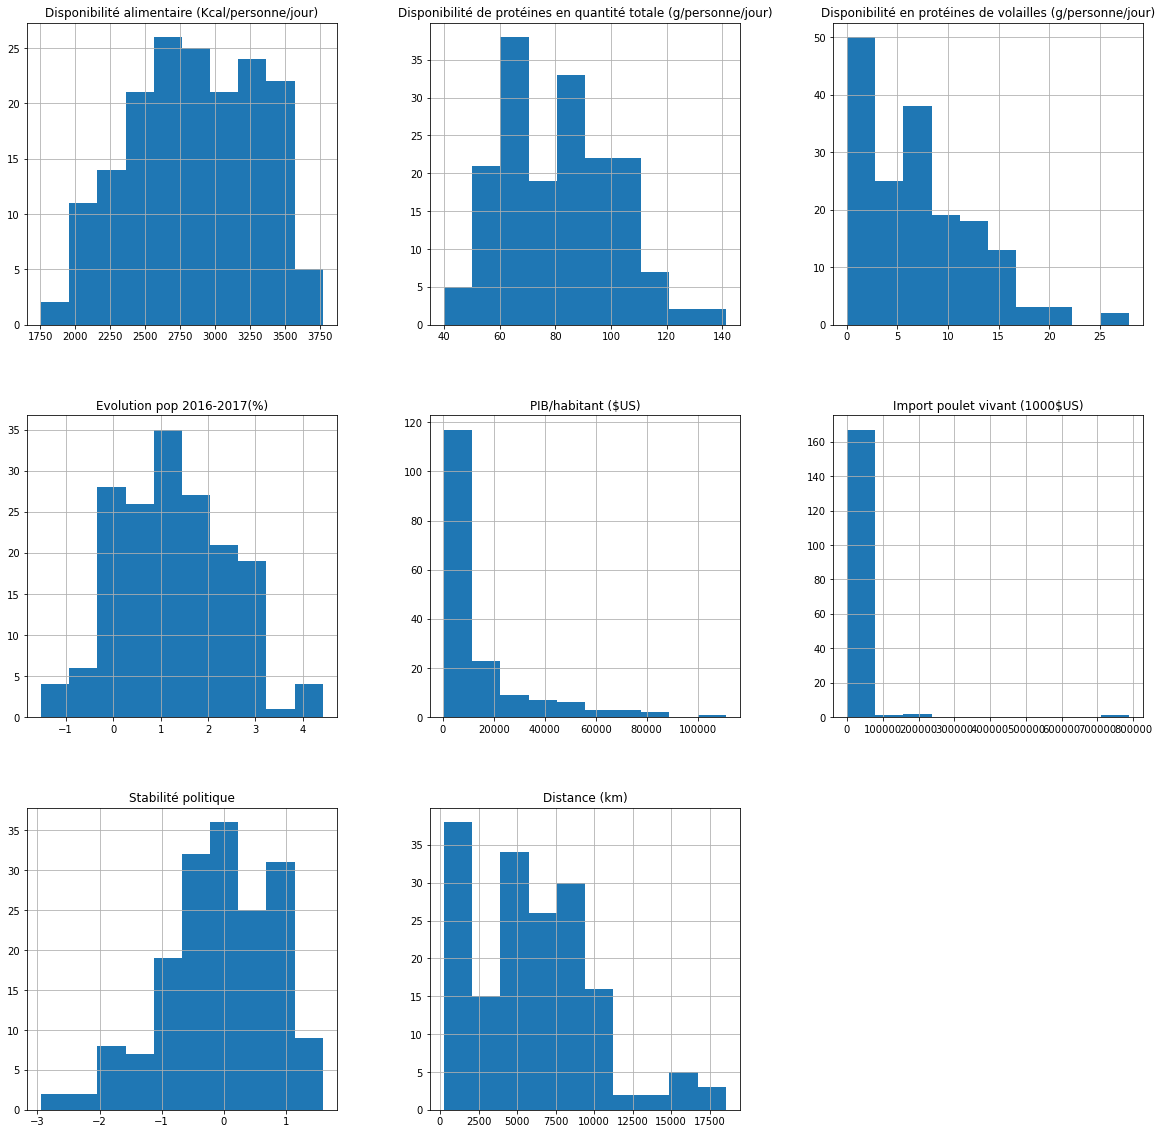

In [3]:
features = df_first.columns
df_first[features].hist(figsize=(20, 20))
plt.show()

### On constate que nos variables ne suivent pas toutes une distibution normale, de plus, elles ont des ordres de grandeurs différents, ce qui peut altérer les algorithmmes de classification utilisant des distances euclidiennes, donc il va falloir centrer et réduire nos données.

## ACP - Analyse en composantes principale

In [4]:
df_first.set_index('Pays', inplace=True)
# on met en numpy
X = df_first.values
print(X.shape)
type(X)

(171, 8)


numpy.ndarray

In [5]:
# on fit et on transforme
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [6]:
#On s'attend donc  avoir pour nos 8 dimensions des moyennes à 0 et des ecart-types de 1
index = ['mean', "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[index,:]

,0,1,2,3,4,5,6,7
mean,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
n_components = 8
pca = PCA(n_components=n_components)

In [8]:
# On l'entraine sur nos données
pca.fit(X_scaled)

PCA(n_components=8)

In [9]:
# Variance expliquée pour chaque composantes
pca_explained = pca.explained_variance_ratio_
# on les place dans une varibale et on met en pourcentage 
compo = (pca_explained*100).round(2)
compo

array([45.46, 16.24, 11.18,  9.49,  7.23,  5.16,  3.82,  1.41])

### Ici, la 1ère composante capte 45% de la variance (inertie) totales, et la 2ème 16%..

## Affichons l'eboulis des valeurs propres

In [10]:
# Sommes cumulé des composantes
cumule = compo.cumsum().round()
cumule

array([ 45.,  62.,  73.,  82.,  90.,  95.,  99., 100.])

In [11]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

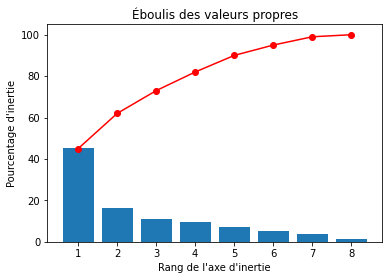

In [12]:
plt.bar(x_list, compo)
plt.plot(x_list, cumule, c='red' ,marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d\'inertie")
plt.title("Éboulis des valeurs propres")
plt.show()

### Les 2 premier axes totalisent 61% (45 + 16), ce qui est un bon taux, regardons le cercles des corrélations à présent.

In [13]:
# Calcul des composantes principales
pcs = pd.DataFrame(pca.components_)
pcs

,0,1,2,3,4,5,6,7
0,0.454830,0.473165,0.357285,-0.337767,0.399836,0.144902,0.347678,-0.160499
1,0.142409,0.085061,-0.397195,0.010147,-0.028415,0.422388,-0.356513,-0.712950
2,-0.196826,-0.189595,-0.017917,0.171680,0.187382,0.833632,0.275806,0.298990
3,0.034925,0.098585,-0.106186,0.773029,0.545557,-0.240910,0.096174,-0.123663
4,0.240662,0.241672,0.481449,0.306478,-0.131925,0.208370,-0.652203,0.267888
5,-0.482682,-0.299418,0.649218,-0.031786,0.154646,-0.007088,-0.054400,-0.477438
6,-0.177327,-0.072829,-0.205586,-0.404740,0.674282,-0.058314,-0.487860,0.247200
7,-0.640737,0.754886,-0.086285,0.002962,-0.102975,0.027269,0.019111,0.020896


In [14]:
# Affichage des composantes
feature = df_first.columns
pcs.columns = feature
pcs.index= [f"F{i}" for i in x_list]
pcs.round(2)

,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
F1,0.45,0.47,0.36,-0.34,0.40,0.14,0.35,-0.16
F2,0.14,0.09,-0.40,0.01,-0.03,0.42,-0.36,-0.71
F3,-0.20,-0.19,-0.02,0.17,0.19,0.83,0.28,0.30
F4,0.03,0.10,-0.11,0.77,0.55,-0.24,0.10,-0.12
F5,0.24,0.24,0.48,0.31,-0.13,0.21,-0.65,0.27
F6,-0.48,-0.30,0.65,-0.03,0.15,-0.01,-0.05,-0.48
F7,-0.18,-0.07,-0.21,-0.40,0.67,-0.06,-0.49,0.25
F8,-0.64,0.75,-0.09,0.00,-0.10,0.03,0.02,0.02


## Cercles des corrélations

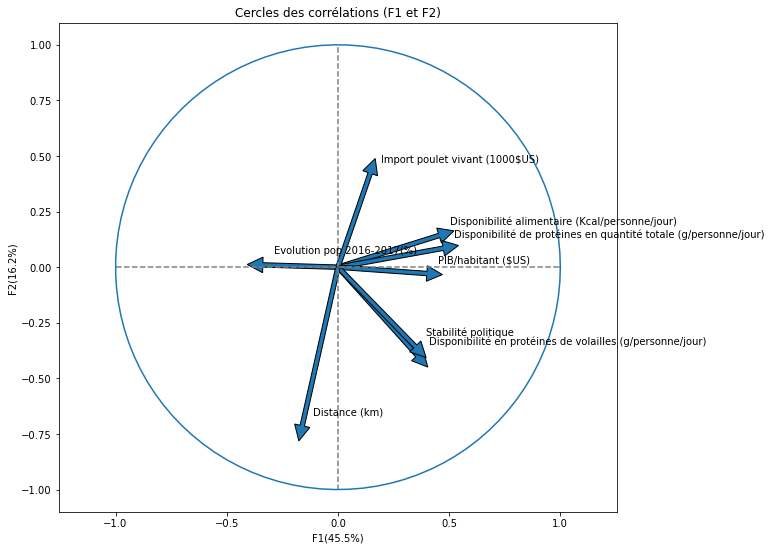

In [15]:
# Cercles de corrélations du 1er plan factorielle
x,y = 0,1
fig, ax = plt.subplots(figsize=(10,9))

for i in range(0, pca.components_.shape[1]) :
    ax.arrow(  0,
               0,
               pca.components_[0,i],
               pca.components_[1,i],
               head_width = 0.07,
               head_length = 0.07,
               width=0.02)
    
    plt.text(pca.components_[0,i] + 0.05,
             pca.components_[1,i] + 0.05,
             feature[i])
    
plt.plot([-1,1],[0,0], color='grey', ls='--')
plt.plot([0,0],[-1,1], color='grey', ls='--')

plt.xlabel('F{}({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{}({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercles des corrélations (F{} et F{})".format(x+1,y+1))

an = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis("equal")
plt.show()
                

### Les disponibiltés alimentaire sont corrélés à l'axe 1, ainsi que le PIB et l'évolution de la population qui est anticorrélé à l'axe 1. En d'autres termes, quand la disponibilité alimentaire augmente, le PIB croît égalemnt pendant que la population décroît.  On pourrait qualifier cet axe de régime alimentaire.

### L'axe 2 est corrélé à l'importation de poulet et distance négativement, donc quand l'importation de poulet croît, les distances à la France décroit, ce qui est plûtot une bonne nouvelle pour nos exportations de poulet. Nous pourrions appelé cet axe marché commerciale.

In [16]:
# on enregistre la contibution inertiel de chaque pays sur les composantes principales.
X_projected = pca.transform(X_scaled)

df_compo = pd.DataFrame(X_projected, index=df_first.index, columns=["F" + str(i+1) for i in range(8)]).iloc[:, :4]
df_compo.head() 

,F1,F2,F3,F4
Pays,,,,
Afghanistan,-3.601293,1.376435,-0.013613,0.107589
Afrique du Sud,0.199473,-0.979295,-0.063379,-0.325573
Albanie,1.944123,0.964273,-1.240387,-0.700283
Algérie,-0.118549,1.829757,-0.849874,0.495459
Allemagne,3.034255,2.076480,1.801881,0.106096


## Projections des individus sur le 1er plan factoriel

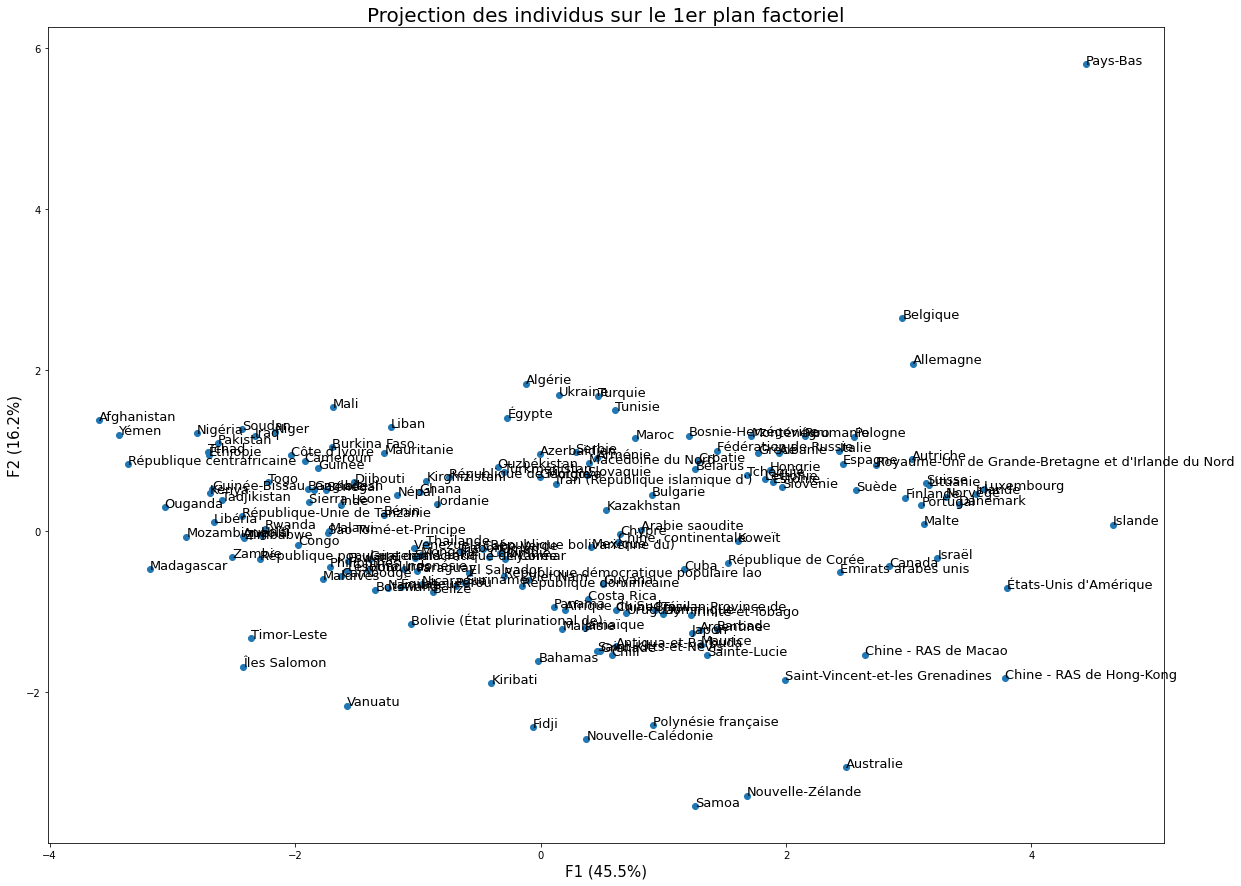

In [17]:
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 15))

plt.scatter(X_projected[:, 0], X_projected[:, 1])
for i,(x,y) in enumerate(X_projected[:,[0,1]]):
                    plt.text(x, y, df_compo.index[i], fontsize='13') 

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=15)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=15)
plt.title("Projection des individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.show()

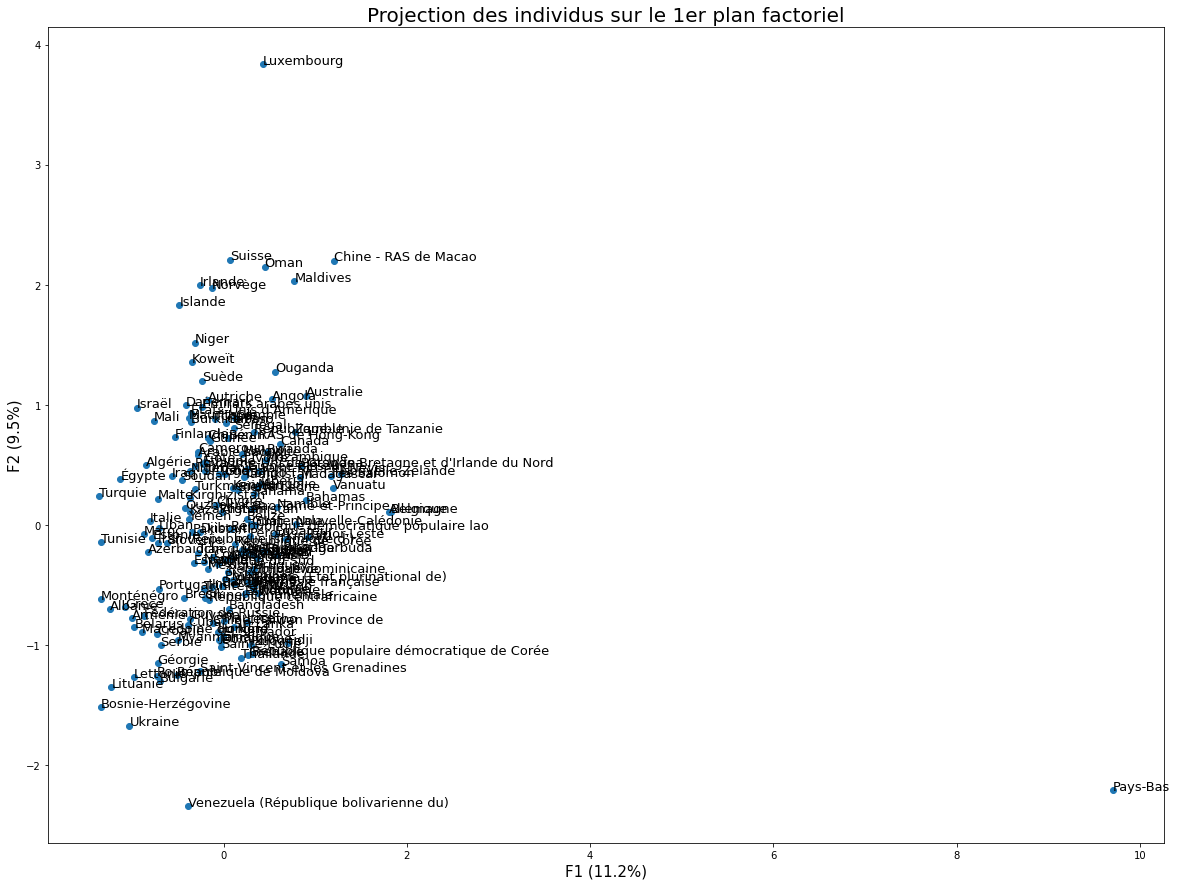

In [22]:
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 15))

plt.scatter(X_projected[:, 2], X_projected[:, 3])
for i,(x,y) in enumerate(X_projected[:,[2,3]]):
                    plt.text(x, y, df_compo.index[i], fontsize='13') 

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[2],1)), fontsize=15)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[3],1)), fontsize=15)
plt.title("Projection des individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.show()

### On comprend grâce à l'ACP que les pays à droite sur ce plan représente les pays avec une forte disponibilité alimentaire ayant un Pib croissant et dont la stabilité politique est plûtot bonne.

                       **************************************

## Classification ascendante hierarchique

In [18]:
# Calcul des ditance euclidiennes selon la méthode de Ward
Z = linkage(X_scaled, method = 'ward', metric='euclidean')

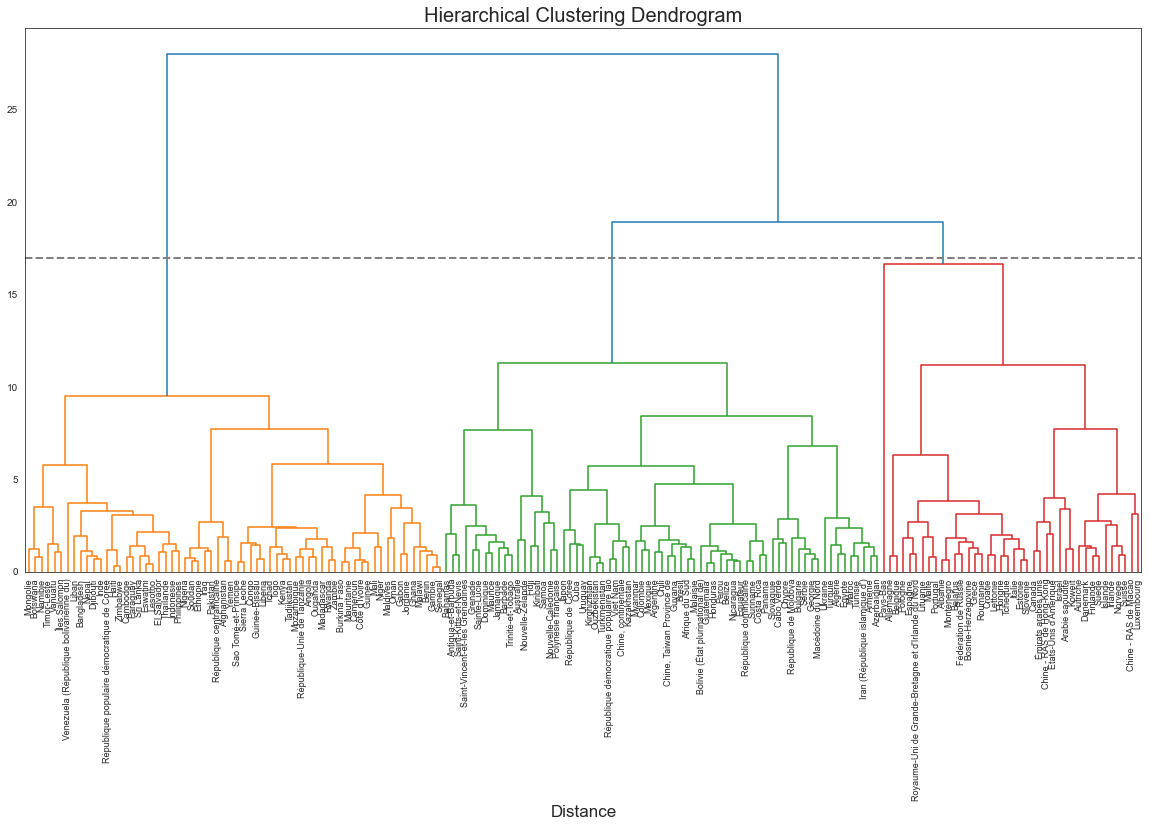

In [19]:
# Affichage du Dendogramme
fig = plt.figure(figsize=(20,10))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Distance', fontsize=17)

dendrogram(Z, labels = df_first.index, leaf_font_size=9, color_threshold=18)
#affichage en pointillé de la ligne de coupe
plt.axhline(y=17, c='grey', lw=2, linestyle='dashed')
plt.show()


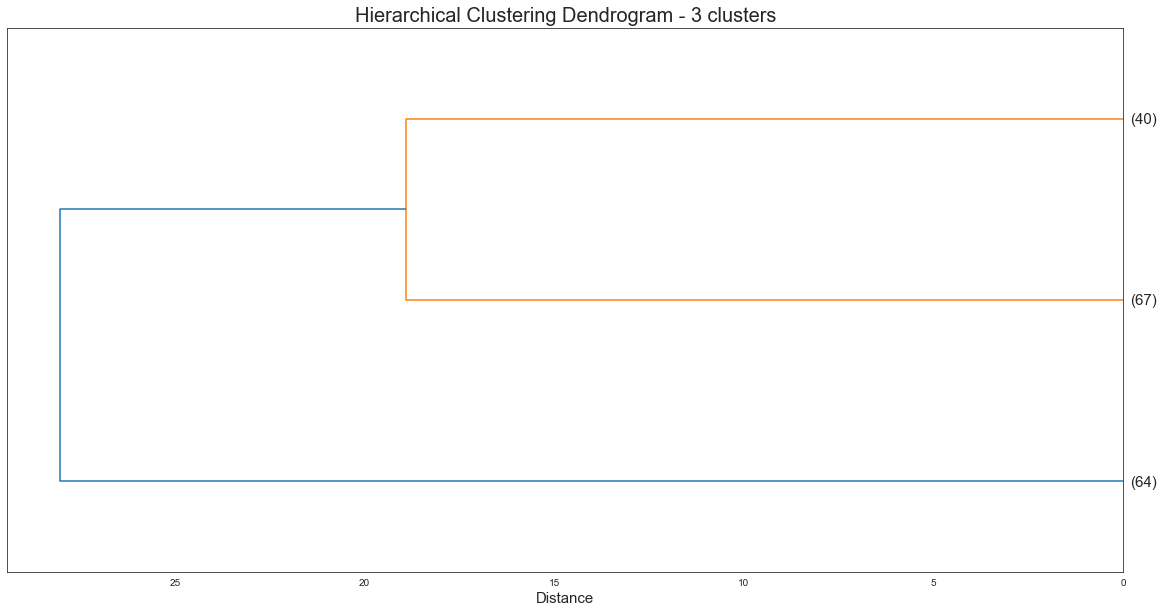

In [20]:
# dendogramme regroupé par nombre d'individu pour chaque classe
fig = plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram - 3 clusters', fontsize=20)
plt.xlabel('Distance', fontsize=15)

dendrogram(Z, labels = df_first.index, p=3, orientation='left', truncate_mode='lastp', leaf_font_size=15)
plt.show()

In [21]:
# 3 classes se forment par la CAH, ajoutons une dimension (colonne) 
# à notre tableau en créant une colonne qui affiche le numéro du classe pour chaque individu (pays).
cah_cluster = fcluster(Z, 3, criterion='maxclust')

idx_c = np.argsort(cah_cluster)

df_cah_cluster = pd.DataFrame(df_first.index[idx_c], cah_cluster[idx_c]).reset_index()
df_cah_cluster = df_cah_cluster.rename(columns={'index':'Classe'})

In [22]:
# on merge nos classes à notre jeu de données
df_first_cah = pd.merge(df_first, df_cah_cluster, on='Pays')
df_first_cah.head()

,Pays,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km),Classe
0,Afghanistan,1997.0,54.09,0.54,2.58,520.62,26227.0,-2.80,5594,1
1,Afrique du Sud,2987.0,83.36,14.11,1.43,6121.88,7394.0,-0.28,9306,2
2,Albanie,3400.0,119.50,6.26,-0.07,4514.20,3266.0,0.38,1603,3
3,Algérie,3345.0,92.85,1.97,2.07,4109.70,19051.0,-0.92,1345,2
4,Allemagne,3559.0,104.07,7.96,0.57,44651.83,193759.0,0.59,880,3


In [23]:
# on affiche les centroides de nos classes
df_radar = df_first_cah.groupby('Classe').mean()
df_radar

,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
Classe,,,,,,,,
1,2448.437500,62.631250,2.395625,2.204844,2616.921406,3500.625000,-0.644219,6796.140625
2,2918.462687,83.311045,9.566418,0.908209,10873.514801,6409.104478,0.087811,7716.955224
3,3396.275000,106.571500,10.541000,0.409000,37021.753250,44695.300000,0.579250,2258.525000


### Nous voyons sur ce tableau les centroides (moyennes) de chaque classe, représentons les visuellement pour mieux les commenté. Mais avant passons les données en min max  pour scaler les données dans un intervalle de [0-1]

In [24]:
# Mise à l'échelle Min max
min_max_scaler = MinMaxScaler()
Y_scaled = min_max_scaler.fit_transform(df_radar)

Y_scaled = pd.DataFrame(Y_scaled, columns=df_radar.columns)
Y_scaled

,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
0,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.831304
1,0.495892,0.470634,0.880351,0.27798,0.239984,0.070603,0.598323,1.000000
2,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000


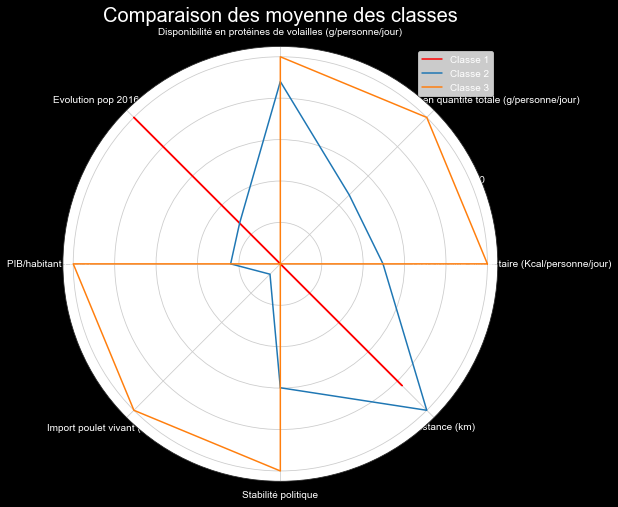

In [25]:
# Affichage d'un radar pour visualisation centroides.
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams.update({'text.color' : "white",'xtick.color' : "white",'ytick.color' : "white"})

categories = df_radar.columns

classe_1 = Y_scaled.iloc[0]
classe_2 = Y_scaled.iloc[1]
classe_3 = Y_scaled.iloc[2]

classe_1 = np.append(classe_1, 0)
classe_2 = np.append(classe_2, 0.4958)
classe_3 = np.append(classe_3, 1)

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(classe_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, classe_1, label='Classe 1',c='red')
plt.plot(label_loc, classe_2, label='Classe 2')
plt.plot(label_loc, classe_3, label='Classe 3')
plt.title('Comparaison des moyenne des classes', size=20)
lines, labels = plt.thetagrids(range(0, 360, int(360/len(categories))), (categories))
plt.legend()
plt.show()

### Nous voyons sur la radar ci-dessus que la classe 3 ( ligne orange) à de bonnes disponibilités alimentaires, des PIB croissant avec un bonne stabilité politique et enfin un bon niveau d'importation de poulet.

In [26]:
df_classe3_cah = df_first_cah[df_first_cah['Classe'] == 3]
df_classe3_cah['Pays'].unique()

array(['Albanie', 'Allemagne', 'Arabie saoudite', 'Autriche', 'Belgique',
       'Bosnie-Herzégovine', 'Bélarus', 'Canada',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Croatie',
       'Danemark', 'Espagne', 'Estonie', 'Finlande',
       'Fédération de Russie', 'Grèce', 'Hongrie', 'Irlande', 'Islande',
       'Israël', 'Italie', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg',
       'Malte', 'Monténégro', 'Norvège', 'Pays-Bas', 'Pologne',
       'Portugal', 'Roumanie',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Slovénie',
       'Suisse', 'Suède', 'Tchéquie', 'Émirats arabes unis',
       "États-Unis d'Amérique"], dtype=object)

In [27]:
df_classe3_cah['Pays'].count()

40

### La CAH nous sélectionne une liste de 40 pays candidats à nos exportations, cela parait être une trop grande liste, de plus il y a des pays de l'UE et hors UE assez lointain comme Macao ou Hong kong..

## Comparons à présent avec cette liste de 40 pays avec l'algorithme du K-means

                              ***********************************

## Algorithme K-means

### Voyons les inerties en fonction d'un nombre de cluster K differents

### Méthode du coude

In [28]:
# Une liste vide pour enregistrer les inerties :  
liste_inertie = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

for k in k_list : 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    liste_inertie.append(kmeans.inertia_)

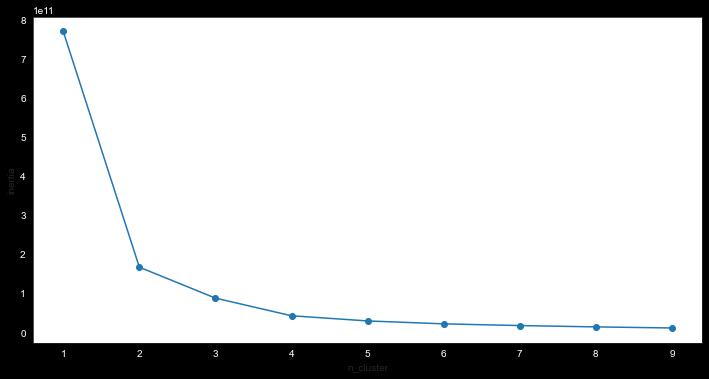

In [29]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, liste_inertie, marker='o')

### Le coude est très clairement sur 2 cluster mais on voit qu'il se prolonge jusqu'a 4 cluster. Voyons avec le score silhouette ce que cela donne.

### Score silhouette

In [30]:
#Calcul  de la métrique "silhouette"
silhouettes = [] 


for k in range(2, 10): 
    clust = cluster.KMeans(n_clusters=k)  
    clust.fit(X)
    
    #Stockage des coefficients associés
    coef_sil = metrics.silhouette_score(X, clust.labels_)
    silhouettes.append(coef_sil)

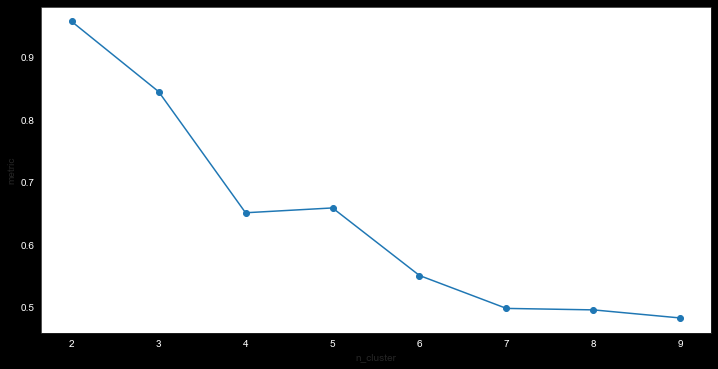

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

ax.set_ylabel("metric")
ax.set_xlabel("n_cluster")

ax = plt.plot(range(2,10), silhouettes, marker='o')

### Le score silhouette, là encore, nous indique un nombre de cluster idéale à 2 mais nous voyons un sursaut à 5 clusters, le coude nous suggérait jusque 4 cluster. La CAH a partitionné nos données en 3 clusters. Réalisons un K-means pour comparer avec la CAH.

                                 *************************************

## Algorithme du K-means

### Réalisons un K-means sur 3, 4 et 5 clusters

In [32]:
cluster3 = cluster.KMeans(n_clusters=3)
cluster3.fit(X_scaled)

KMeans(n_clusters=3)

In [33]:
cluster4 = cluster.KMeans(n_clusters=4)
cluster4.fit(X_scaled)

KMeans(n_clusters=4)

In [34]:
cluster5 = cluster.KMeans(n_clusters=5)
cluster5.fit(X_scaled)

KMeans(n_clusters=5)

In [35]:
# On récupère les cluster de chaque individu
clust3 = cluster3.labels_
clust4 = cluster4.labels_
clust5 = cluster5.labels_

### Maintenant que le K-means à travaillé, affichons les résultat sur le 1er plan factoriel et comparons .

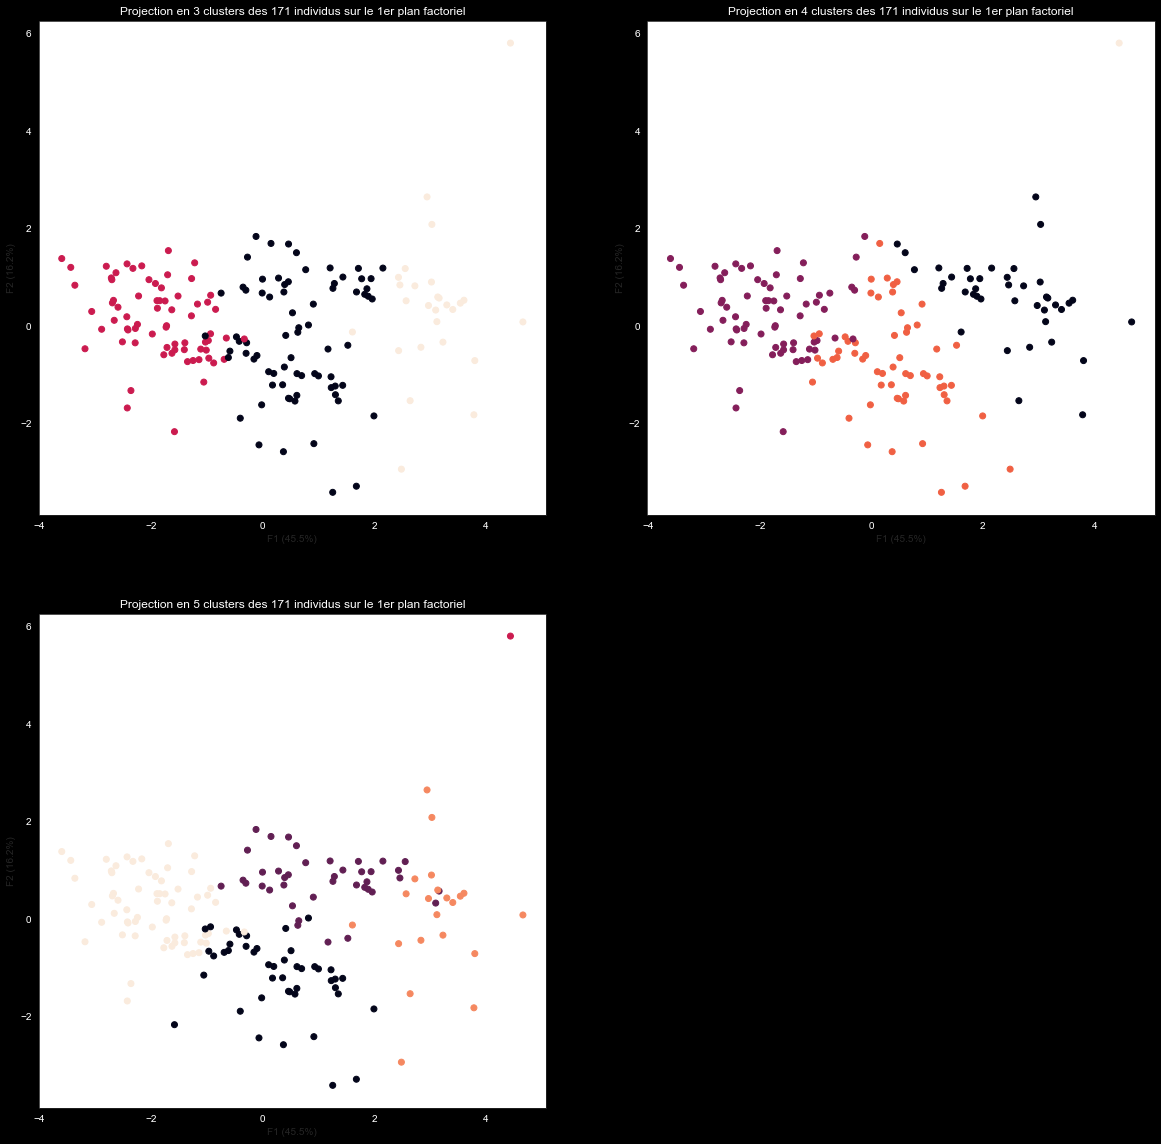

In [36]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 20))

plt.subplot(221)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=cluster3.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.subplot(222)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=cluster4.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 4 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.subplot(223)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=cluster5.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.show()


### Nous constatons sur ces projections que le k-means 3 cluster à des groupes homogènes et aussi l'outlier tout en haut a droite est compris dans un cluster. Sur les k-means en 4 et 5 clusters, ces derniers se chevauchent, et l'outlier est systématiquement dans un cluster isolé. Regardons les résultat du k-means 3 clusters.

In [37]:
#On tri et on attribue chaque individu son cluster.

idx_k = np.argsort(clust3)

df_km_cluster = pd.DataFrame(df_first.index[idx_k], clust3[idx_k]).reset_index()
df_km_cluster = df_km_cluster.rename(columns={'index':'Cluster'})

In [38]:
# on merge nos classes à notre jeu de données
df_first_km = pd.merge(df_first, df_km_cluster, on='Pays')
df_first_km.head()

,Pays,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km),Cluster
0,Afghanistan,1997.0,54.09,0.54,2.58,520.62,26227.0,-2.80,5594,1
1,Afrique du Sud,2987.0,83.36,14.11,1.43,6121.88,7394.0,-0.28,9306,0
2,Albanie,3400.0,119.50,6.26,-0.07,4514.20,3266.0,0.38,1603,0
3,Algérie,3345.0,92.85,1.97,2.07,4109.70,19051.0,-0.92,1345,0
4,Allemagne,3559.0,104.07,7.96,0.57,44651.83,193759.0,0.59,880,2


In [40]:
df_cent_3 = df_first_km.groupby('Cluster').mean()
df_cent_3

,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
Cluster,,,,,,,,
0,3004.486486,86.887838,9.407162,0.585676,11416.559346,7887.216216,0.120450,6370.648649
1,2467.414286,63.460143,2.763857,2.226000,2663.124857,3979.471429,-0.599714,6982.600000
2,3445.814815,110.414444,12.085556,0.709630,49838.313333,58483.148148,0.773704,3041.481481


### Les meilleures carateristiques pour nos exportations de poulets se retrouvent dans le cluster 2 avec des distances a la france faible, de forte dispo alimentaire, un bon pouvoir d'achat..

In [46]:
# affichons les pays du Cluster  2
df_first_km = df_first_km[df_first_km['Cluster'] == 2]
df_first_km['Pays'].unique()

array(['Allemagne', 'Australie', 'Autriche', 'Belgique', 'Canada',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Danemark',
       'Espagne', 'Finlande', 'Irlande', 'Islande', 'Israël', 'Italie',
       'Koweït', 'Lituanie', 'Luxembourg', 'Malte', 'Norvège', 'Pays-Bas',
       'Pologne', 'Portugal',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suisse',
       'Suède', 'Émirats arabes unis', "États-Unis d'Amérique"],
      dtype=object)

In [47]:
df_first_km['Pays'].count()

27

### Le k-means à en quelques sorte affiner la sélection des 40 pays obtenue plus haut avec la CAH, le K-means en 3 cluster nous en proposent 27.

In [48]:
df_first_km.groupby('Cluster').mean()

,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité totale (g/personne/jour),Disponibilité en protéines de volailles (g/personne/jour),Evolution pop 2016-2017(%),PIB/habitant ($US),Import poulet vivant (1000$US),Stabilité politique,Distance (km)
Cluster,,,,,,,,
2,3445.814815,110.414444,12.085556,0.70963,49838.313333,58483.148148,0.773704,3041.481481


In [49]:
df_select1 = df_first_km[df_first_km['Distance (km)'] <= 3041]
df_select2 = df_select1[df_select1['Stabilité politique'] > 0]
df_select2 = df_select2[df_select2['Evolution pop 2016-2017(%)'] > 0]
df_select2['Pays'].unique()

array(['Allemagne', 'Autriche', 'Belgique', 'Danemark', 'Espagne',
       'Finlande', 'Irlande', 'Islande', 'Italie', 'Luxembourg', 'Malte',
       'Norvège', 'Pays-Bas',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suisse',
       'Suède'], dtype=object)

In [50]:
df_select2['Pays'].count()

16

### Ci-dessus, j'ai affiner la liste des 27 pays, en prenant les pays dont la distance est inférieur à la moyenne du cluster, aussi en choisissant les pays dont la stabilité politique est supérieur à 0 ainsi que l'évolution population positive.

#             --------------------- FIN DE L'ANALYSE ---------------------